In [12]:
# Import the required modules
from skimage.transform import pyramid_gaussian
from skimage.io import imread
from skimage.feature import hog
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import cv2
import glob
import os

In [2]:
def sliding_window(image, window_size, step_size):
    '''
    This function returns a patch of the input image `image` of size equal
    to `window_size`. 
    => The first image returned top-left co-ordinates (0, 0) 
    and are increment in both x and y directions by the `step_size` supplied.
    So, the input parameters are -
    * `image` - Input Image
    * `window_size` - Size of Sliding Window
    * `step_size` - Incremented Size of Window
    The function returns a tuple -
    (x, y, im_window)
    where
    * x is the top-left x co-ordinate
    * y is the top-left y co-ordinate
    * im_window is the sliding window image
    '''
    for y in range(0, image.shape[0], step_size[1]):
        for x in range(0, image.shape[1], step_size[0]):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])


In [3]:
def overlapping_area(detection_1, detection_2):
    '''
    Function to calculate overlapping area'si
    `detection_1` and `detection_2` are 2 detections whose area
    of overlap needs to be found out.
    Each detection is list in the format ->
    [x-top-left, y-top-left, confidence-of-detections, width-of-detection, height-of-detection]
    The function returns a value between 0 and 1,
    which represents the area of overlap.
    0 is no overlap and 1 is complete overlap.
    Area calculated from ->
    http://math.stackexchange.com/questions/99565/simplest-way-to-calculate-the-intersect-area-of-two-rectangles
    '''
    # Calculate the x-y co-ordinates of the 
    # rectangles
    x1_tl = detection_1[0]
    x2_tl = detection_2[0]
    x1_br = detection_1[0] + detection_1[3]
    x2_br = detection_2[0] + detection_2[3]
    y1_tl = detection_1[1]
    y2_tl = detection_2[1]
    y1_br = detection_1[1] + detection_1[4]
    y2_br = detection_2[1] + detection_2[4]
    # Calculate the overlapping Area
    x_overlap = max(0, min(x1_br, x2_br)-max(x1_tl, x2_tl))
    y_overlap = max(0, min(y1_br, y2_br)-max(y1_tl, y2_tl))
    overlap_area = x_overlap * y_overlap
    area_1 = detection_1[3] * detection_2[4]
    area_2 = detection_2[3] * detection_2[4]
    total_area = area_1 + area_2 - overlap_area
    return overlap_area / float(total_area)

def nms(detections, threshold=.1):
    '''
    This function performs Non-Maxima Suppression.
    `detections` consists of a list of detections.
    Each detection is in the format ->
    [x-top-left, y-top-left, confidence-of-detections, width-of-detection, height-of-detection]
    If the area of overlap is greater than the `threshold`,
    the area with the lower confidence score is removed.
    The output is a list of detections.
    '''
    if len(detections) == 0:
        
        return []
    # Sort the detections based on confidence score
    detections = sorted(detections, key=lambda detections: detections[2],
            reverse=True)
    # Unique detections will be appended to this list
    new_detections=[]
    # Append the first detection
    new_detections.append(detections[0])
    # Remove the detection from the original list
    del detections[0]
    # For each detection, calculate the overlapping area
    # and if area of overlap is less than the threshold set
    # for the detections in `new_detections`, append the 
    # detection to `new_detections`.
    # In either case, remove the detection from `detections` list.
    for index, detection in enumerate(detections):
        for new_detection in new_detections:
            if overlapping_area(detection, new_detection) > threshold:
                del detections[index]
                break
        else:
            new_detections.append(detection)
            del detections[index]
    return new_detections

In [4]:
count=0
nmsDetect=[]
# Load the classifier
clf = joblib.load("models/svm.model")

downscale = 2
min_wdw_sz= [100, 40]
step_size=[5, 5]

list_test=glob.glob(os.path.join("TestImages","*"))
list_test.sort()

for im_path2 in list_test:
    im=imread(im_path2,as_gray=True)
    # List to store the detections
    detections = []
    # The current scale of the image
    scale = 0
    # Downscale the image and iterate
    for im_scaled in pyramid_gaussian(im, downscale):
        # This list contains detections at the current scale
        cd = []
        # If the width or height of the scaled image is less than
        # the width or height of the window, then end the iterations.
        if im_scaled.shape[0] < min_wdw_sz[1] or im_scaled.shape[1] < min_wdw_sz[0]:
            break
        for (x, y, im_window) in sliding_window(im_scaled, min_wdw_sz, step_size):
            if im_window.shape[0] != min_wdw_sz[1] or im_window.shape[1] != min_wdw_sz[0]:
                continue
            # Calculate the HOG features
            fd = hog(im_window, orientations=9, pixels_per_cell=[8, 8], cells_per_block=[3, 3],block_norm='L1', visualize=False, transform_sqrt=False, feature_vector=True)
            b=fd.reshape(1, -1)
            pred = clf.predict(b)

            if pred == 1:
                #print  ("Detection:: Location -> ({}, {})".format(x, y))
                #print ("Scale ->  {} | Confidence Score {} \n".format(scale,clf.decision_function(b)))
                detections.append((x, y, clf.decision_function(b),
                    int(min_wdw_sz[0]*(downscale**scale)),
                    int(min_wdw_sz[1]*(downscale**scale))))
                cd.append(detections[-1])
            # of the sliding window
            if pred == 0:
                clone = im_scaled.copy()
                for x1, y1, _, _, _  in cd:
                    # Draw the detections at this scale
                    cv2.rectangle(clone, (x1, y1), (x1 + im_window.shape[1], y1 +im_window.shape[0]), (0, 0, 0), thickness=2)
                cv2.rectangle(clone, (x, y), (x + im_window.shape[1], y +im_window.shape[0]), (255, 255, 255), thickness=2)

        # Move the the next scale
        scale+=1
   # print("Numbeer of detections image= %f = "%count, len(detections))
   # print("-----------------------------------------")
    d1=nms(detections)
    d2=nms(d1)
    d3=nms(d2)
    d4=nms(d3)
    #print("Numbeer of detections after nms  image = %f = "%count , len(d4))
    nmsDetect.append(d4)
   # print("Length of nmsDetect= ",len(nmsDetect))
    count+=1

In [5]:
# Extract x ,y,w,h from nmsDetect
x=[]
y=[]
w=[]
h=[]
for xx in range(169):
    for x_tl, y_tl, _, w_tl, h_tl in nmsDetect[xx]:
        pass
    x.append(x_tl)    
    y.append(y_tl)
    w.append(w_tl)
    h.append(h_tl)


# Intersection over Union (IoU) 

In [6]:
#https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

In [7]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [8]:
# put test images in list
i=[]
for im_path2 in list_test:
    i.append(im_path2)
# put each line trueLocations.txt in list 
p=[]
with open("trueLocations.txt", "r") as f:
        for s in f:
            p.append(s)


In [9]:
# Extract groud truth from text file
o=[] # y
z=[] # x
for a in p:
    o.append(int(a[6:9]))
    z.append(int(a[10:13]))

TestImages/001.pgm:  IOU = 0.0750
------------------------------------------


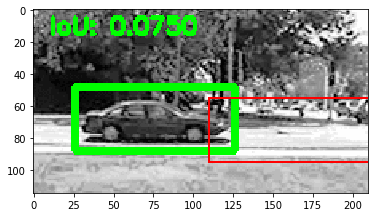

TestImages/002.pgm:  IOU = 0.8250
------------------------------------------


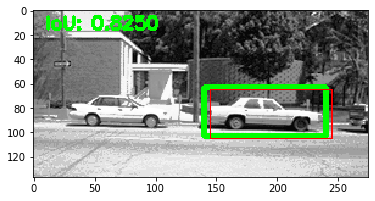

TestImages/003.pgm:  IOU = 1.0000
------------------------------------------


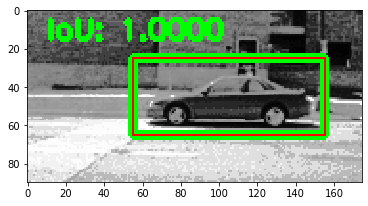

TestImages/004.pgm:  IOU = 0.7942
------------------------------------------


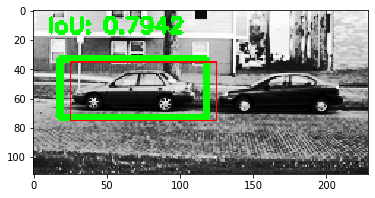

TestImages/005.pgm:  IOU = 1.0000
------------------------------------------


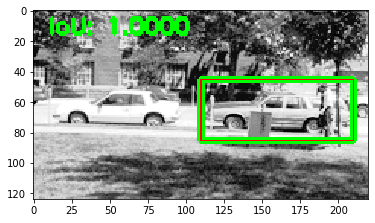

TestImages/006.pgm:  IOU = 0.9057
------------------------------------------


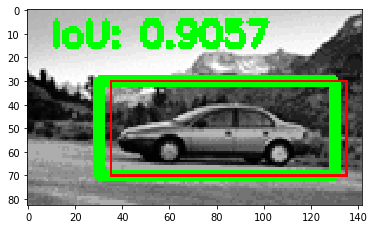

TestImages/007.pgm:  IOU = 0.7841
------------------------------------------


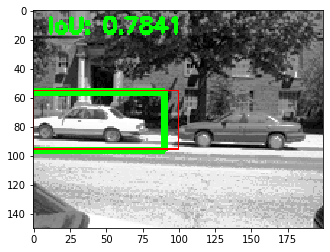

TestImages/008.pgm:  IOU = 0.9804
------------------------------------------


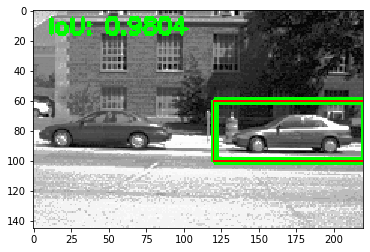

TestImages/009.pgm:  IOU = 0.8323
------------------------------------------


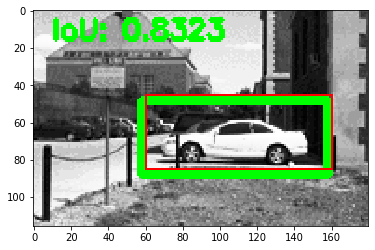

TestImages/010.pgm:  IOU = 0.7872
------------------------------------------


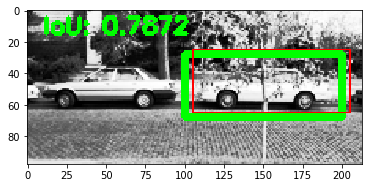

TestImages/011.pgm:  IOU = 0.8733
------------------------------------------


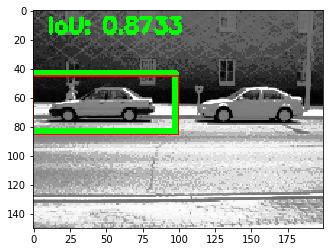

TestImages/012.pgm:  IOU = 0.8250
------------------------------------------


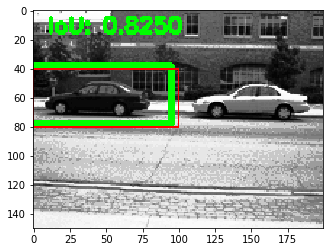

TestImages/013.pgm:  IOU = 0.8645
------------------------------------------


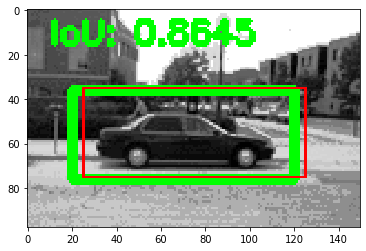

TestImages/014.pgm:  IOU = 0.0000
------------------------------------------


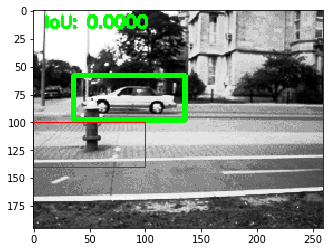

TestImages/015.pgm:  IOU = 0.0811
------------------------------------------


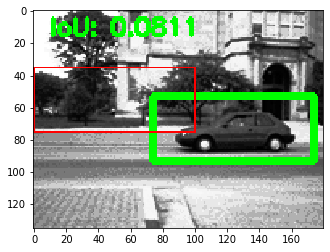

TestImages/016.pgm:  IOU = 0.8570
------------------------------------------


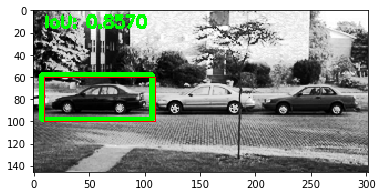

TestImages/017.pgm:  IOU = 0.1057
------------------------------------------


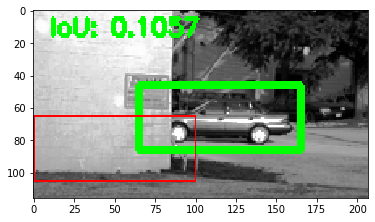

TestImages/018.pgm:  IOU = 0.1219
------------------------------------------


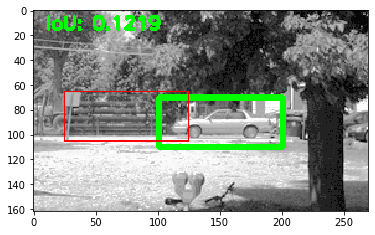

TestImages/019.pgm:  IOU = 0.9524
------------------------------------------


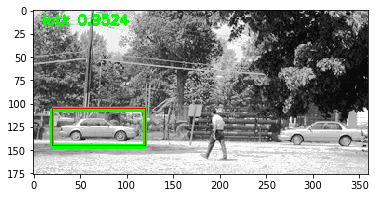

TestImages/020.pgm:  IOU = 0.9070
------------------------------------------


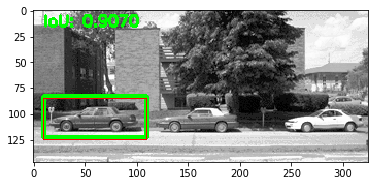

TestImages/021.pgm:  IOU = 1.0000
------------------------------------------


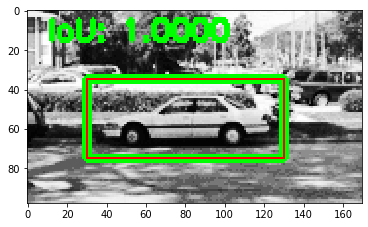

TestImages/022.pgm:  IOU = 0.8222
------------------------------------------


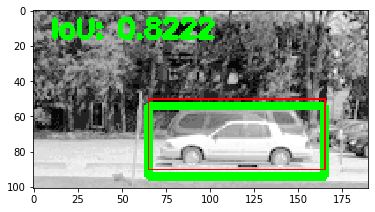

TestImages/023.pgm:  IOU = 0.0402
------------------------------------------


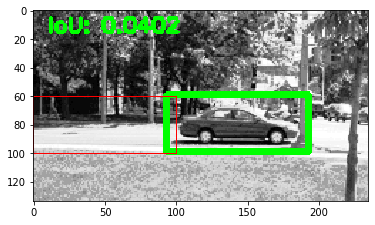

TestImages/024.pgm:  IOU = 0.0706
------------------------------------------


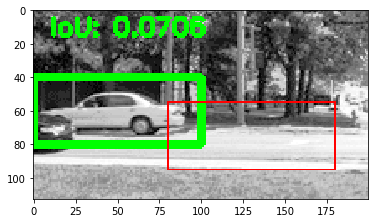

TestImages/025.pgm:  IOU = 0.0085
------------------------------------------


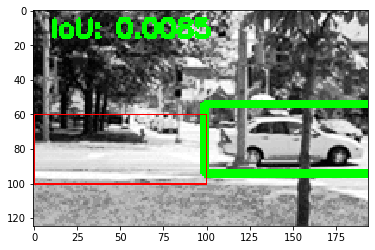

TestImages/026.pgm:  IOU = 0.8645
------------------------------------------


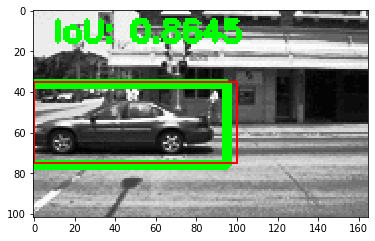

TestImages/027.pgm:  IOU = 0.9070
------------------------------------------


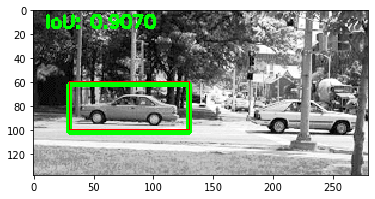

TestImages/028.pgm:  IOU = 0.9341
------------------------------------------


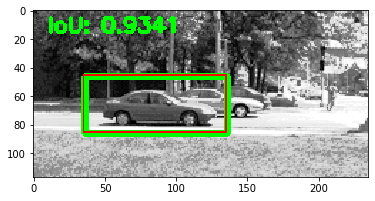

TestImages/029.pgm:  IOU = 0.8570
------------------------------------------


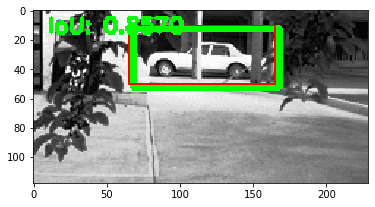

TestImages/030.pgm:  IOU = 0.0000
------------------------------------------


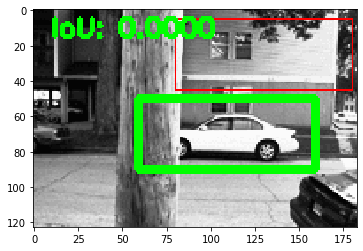

TestImages/031.pgm:  IOU = 0.9162
------------------------------------------


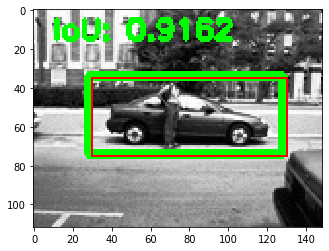

TestImages/032.pgm:  IOU = 0.8409
------------------------------------------


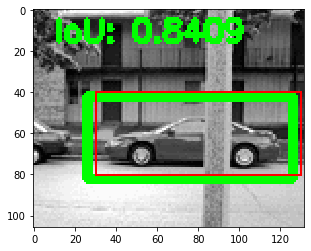

TestImages/033.pgm:  IOU = 0.9612
------------------------------------------


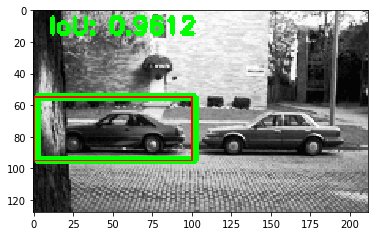

TestImages/034.pgm:  IOU = 0.8570
------------------------------------------


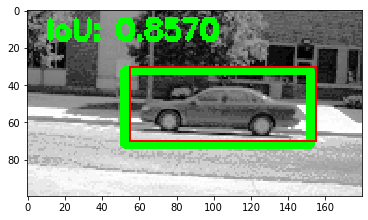

TestImages/035.pgm:  IOU = 0.0000
------------------------------------------


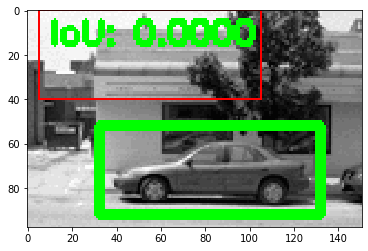

TestImages/036.pgm:  IOU = 0.0456
------------------------------------------


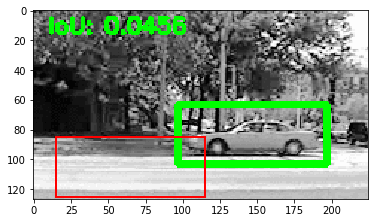

TestImages/037.pgm:  IOU = 0.0000
------------------------------------------


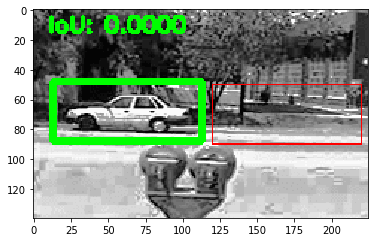

TestImages/038.pgm:  IOU = 0.1213
------------------------------------------


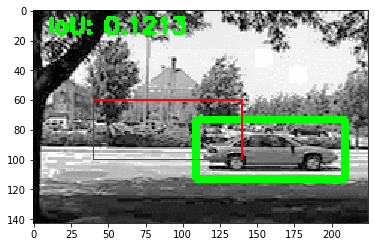

TestImages/039.pgm:  IOU = 0.9162
------------------------------------------


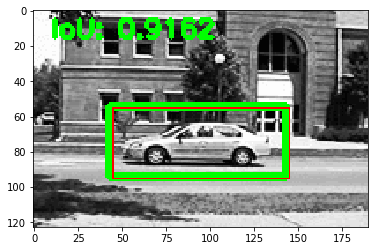

TestImages/040.pgm:  IOU = 0.7648
------------------------------------------


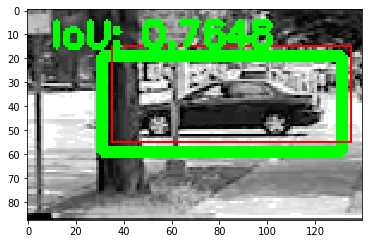

TestImages/041.pgm:  IOU = 0.9238
------------------------------------------


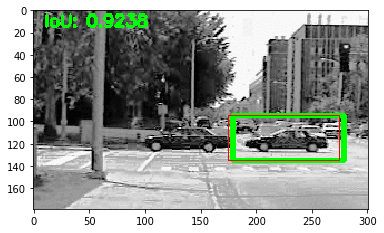

TestImages/042.pgm:  IOU = 0.9612
------------------------------------------


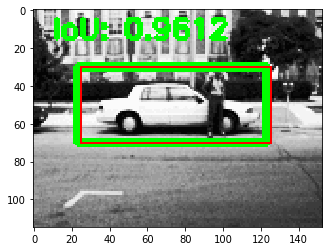

TestImages/043.pgm:  IOU = 0.9070
------------------------------------------


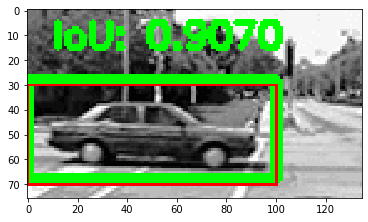

TestImages/044.pgm:  IOU = 0.9524
------------------------------------------


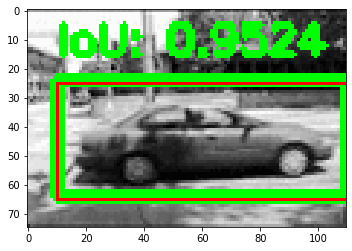

TestImages/045.pgm:  IOU = 0.9162
------------------------------------------


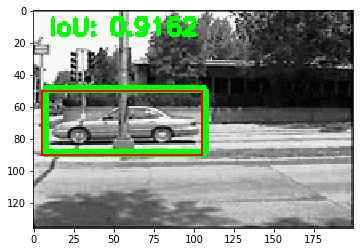

TestImages/046.pgm:  IOU = 0.0443
------------------------------------------


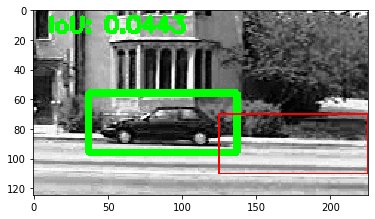

TestImages/047.pgm:  IOU = 0.8075
------------------------------------------


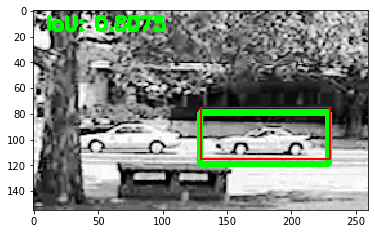

TestImages/048.pgm:  IOU = 1.0000
------------------------------------------


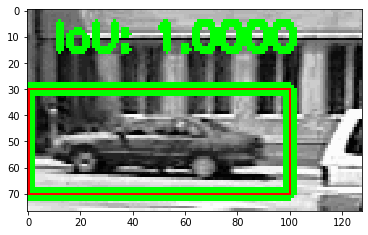

TestImages/049.pgm:  IOU = 0.9162
------------------------------------------


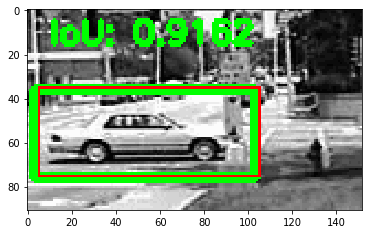

TestImages/050.pgm:  IOU = 1.0000
------------------------------------------


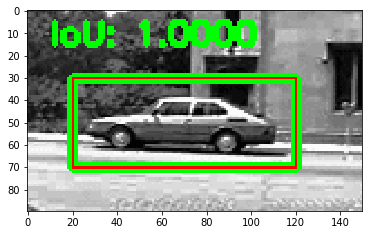

TestImages/051.pgm:  IOU = 0.8636
------------------------------------------


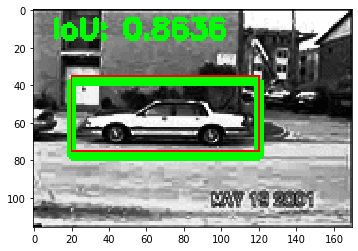

TestImages/052.pgm:  IOU = 0.9804
------------------------------------------


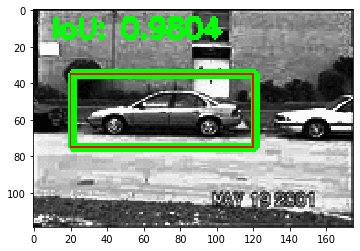

TestImages/053.pgm:  IOU = 0.8636
------------------------------------------


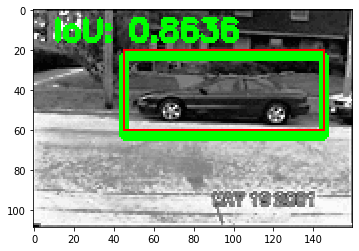

TestImages/054.pgm:  IOU = 0.9341
------------------------------------------


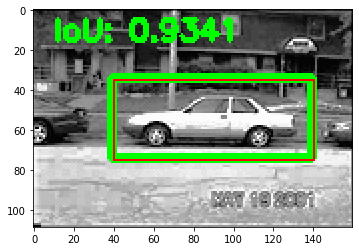

TestImages/055.pgm:  IOU = 0.9238
------------------------------------------


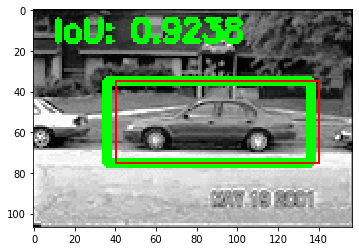

TestImages/056.pgm:  IOU = 0.8900
------------------------------------------


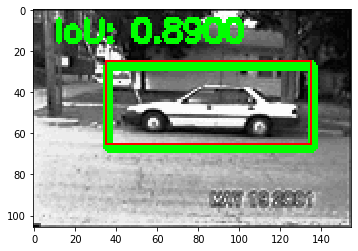

TestImages/057.pgm:  IOU = 1.0000
------------------------------------------


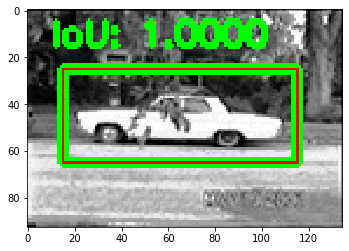

TestImages/058.pgm:  IOU = 1.0000
------------------------------------------


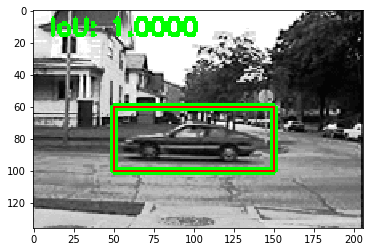

TestImages/059.pgm:  IOU = 0.8814
------------------------------------------


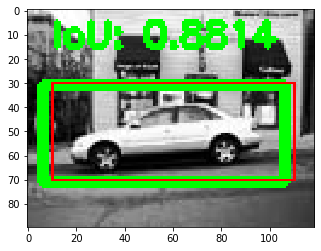

TestImages/060.pgm:  IOU = 0.0073
------------------------------------------


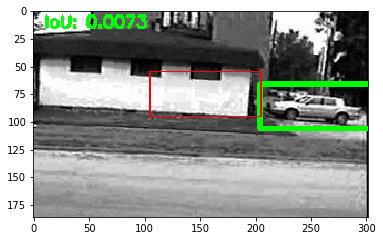

TestImages/061.pgm:  IOU = 0.8900
------------------------------------------


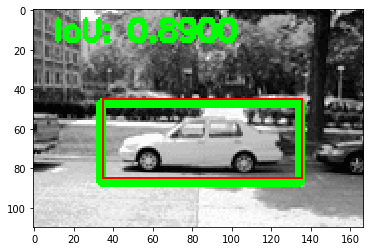

TestImages/062.pgm:  IOU = 0.8154
------------------------------------------


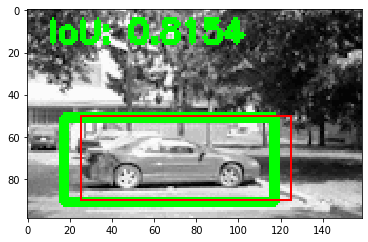

TestImages/063.pgm:  IOU = 0.9070
------------------------------------------


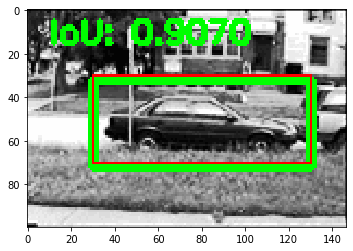

TestImages/064.pgm:  IOU = 0.8570
------------------------------------------


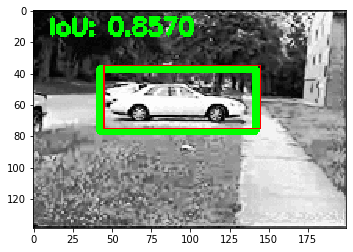

TestImages/065.pgm:  IOU = 0.0305
------------------------------------------


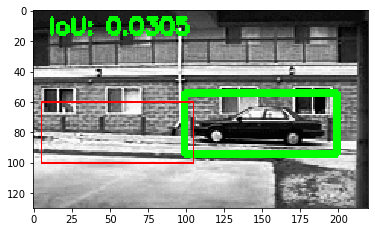

TestImages/066.pgm:  IOU = 1.0000
------------------------------------------


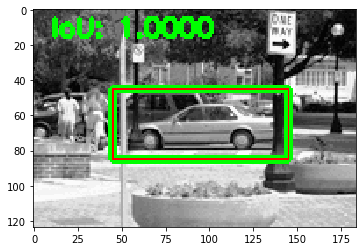

TestImages/067.pgm:  IOU = 0.7872
------------------------------------------


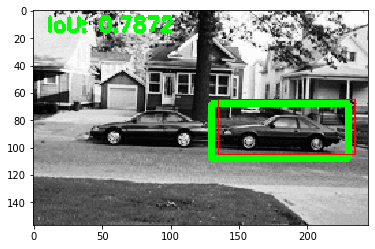

TestImages/068.pgm:  IOU = 0.8733
------------------------------------------


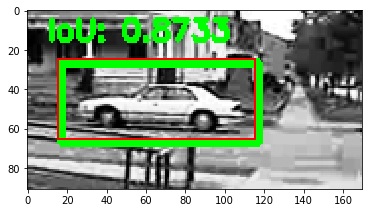

TestImages/069.pgm:  IOU = 0.9162
------------------------------------------


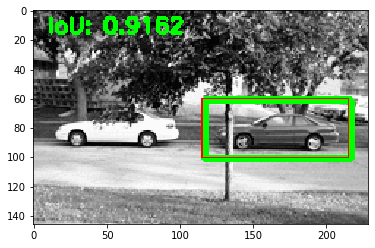

TestImages/070.pgm:  IOU = 0.9341
------------------------------------------


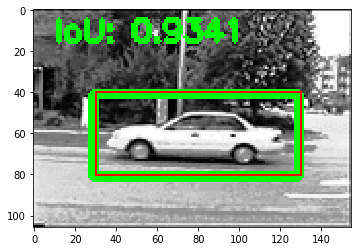

TestImages/071.pgm:  IOU = 0.9341
------------------------------------------


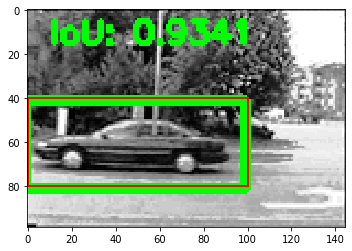

TestImages/072.pgm:  IOU = 0.8323
------------------------------------------


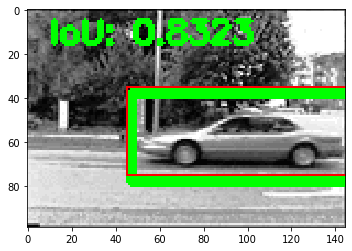

TestImages/073.pgm:  IOU = 0.1405
------------------------------------------


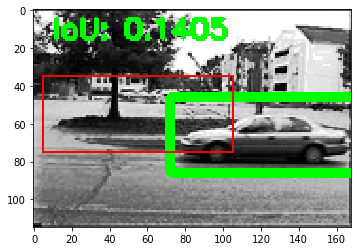

TestImages/074.pgm:  IOU = 0.9524
------------------------------------------


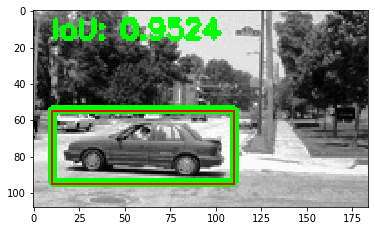

TestImages/075.pgm:  IOU = 0.0000
------------------------------------------


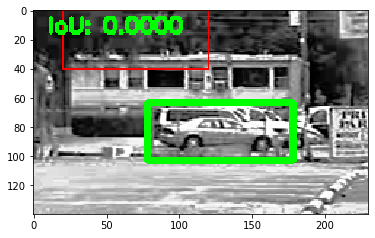

TestImages/076.pgm:  IOU = 0.8733
------------------------------------------


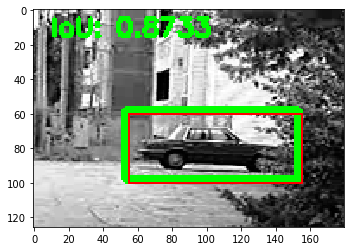

TestImages/077.pgm:  IOU = 0.8250
------------------------------------------


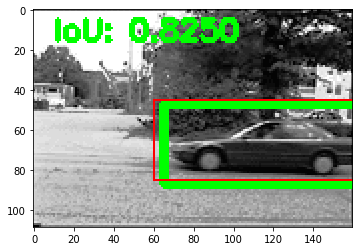

TestImages/078.pgm:  IOU = 0.8814
------------------------------------------


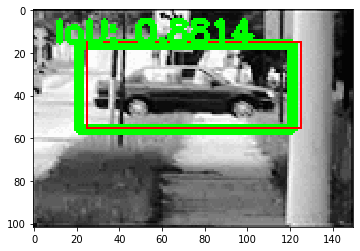

TestImages/079.pgm:  IOU = 0.7689
------------------------------------------


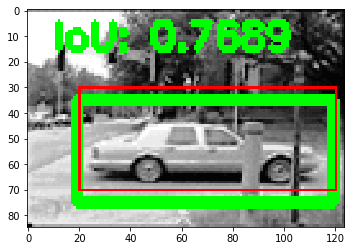

TestImages/080.pgm:  IOU = 0.9341
------------------------------------------


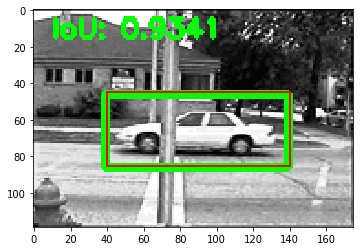

TestImages/081.pgm:  IOU = 0.0419
------------------------------------------


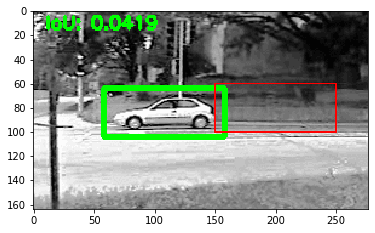

TestImages/082.pgm:  IOU = 0.0000
------------------------------------------


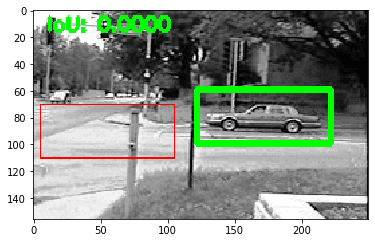

TestImages/083.pgm:  IOU = 0.1330
------------------------------------------


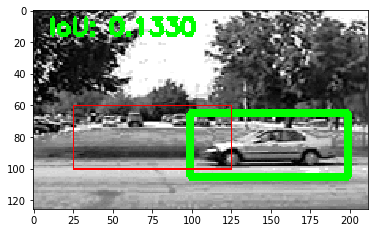

TestImages/084.pgm:  IOU = 0.8814
------------------------------------------


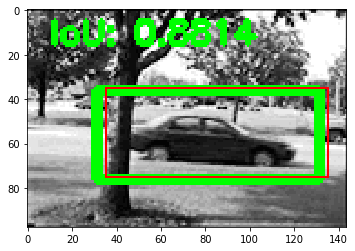

TestImages/085.pgm:  IOU = 0.8814
------------------------------------------


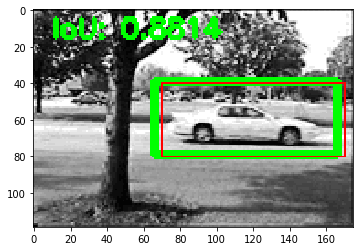

TestImages/086.pgm:  IOU = 0.7788
------------------------------------------


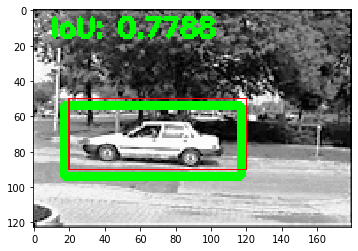

TestImages/087.pgm:  IOU = 0.6394
------------------------------------------


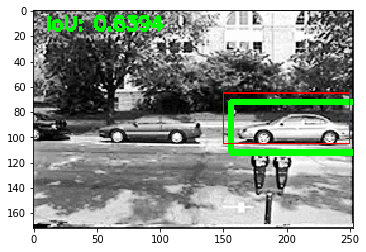

TestImages/088.pgm:  IOU = 0.7648
------------------------------------------


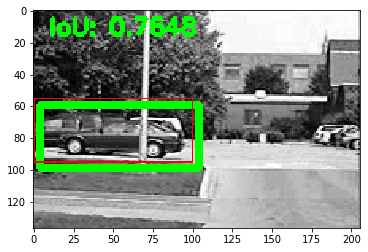

TestImages/089.pgm:  IOU = 0.9524
------------------------------------------


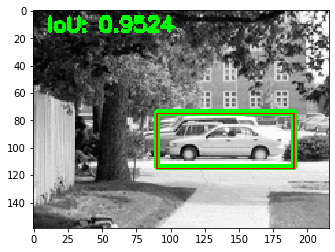

TestImages/090.pgm:  IOU = 0.9612
------------------------------------------


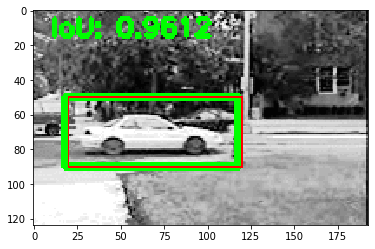

TestImages/091.pgm:  IOU = 0.9524
------------------------------------------


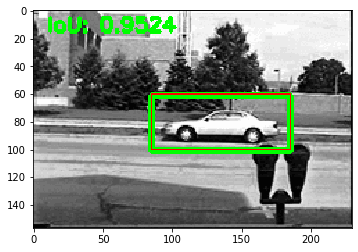

TestImages/092.pgm:  IOU = 0.9423
------------------------------------------


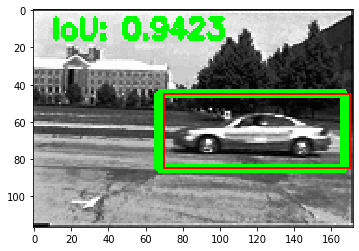

TestImages/093.pgm:  IOU = 0.0000
------------------------------------------


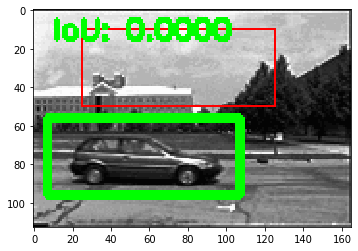

TestImages/094.pgm:  IOU = 0.0439
------------------------------------------


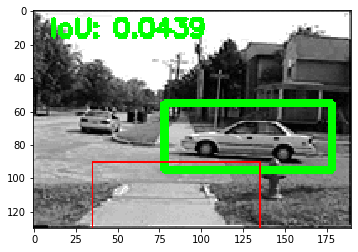

TestImages/095.pgm:  IOU = 0.9162
------------------------------------------


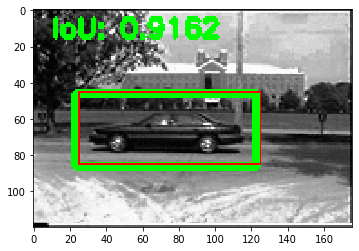

TestImages/096.pgm:  IOU = 0.7930
------------------------------------------


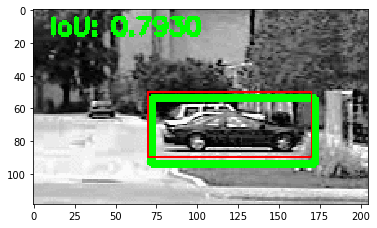

TestImages/097.pgm:  IOU = 0.9524
------------------------------------------


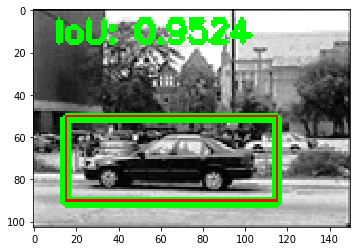

TestImages/098.pgm:  IOU = 0.0943
------------------------------------------


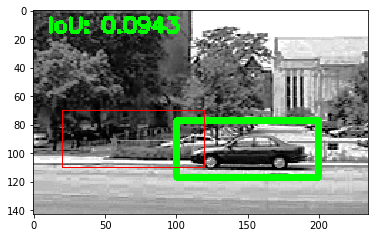

TestImages/099.pgm:  IOU = 0.9162
------------------------------------------


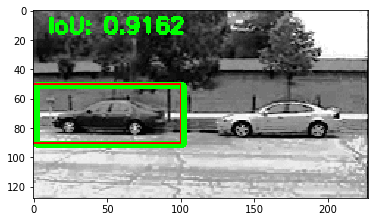

TestImages/100.pgm:  IOU = 0.8315
------------------------------------------


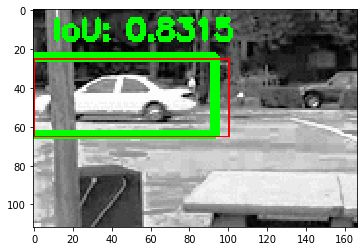

TestImages/101.pgm:  IOU = 0.9612
------------------------------------------


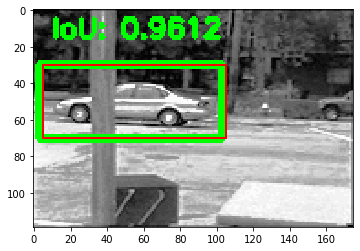

TestImages/102.pgm:  IOU = 0.9341
------------------------------------------


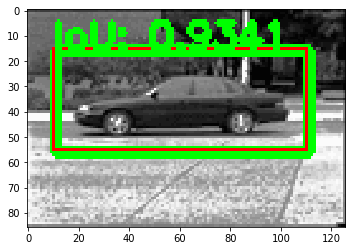

TestImages/103.pgm:  IOU = 0.9524
------------------------------------------


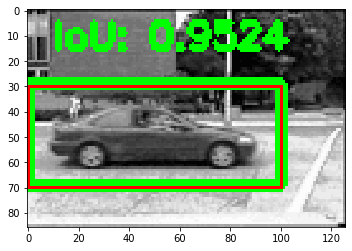

TestImages/104.pgm:  IOU = 0.1842
------------------------------------------


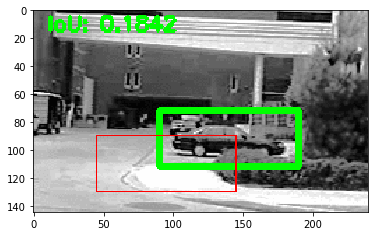

TestImages/105.pgm:  IOU = 0.8323
------------------------------------------


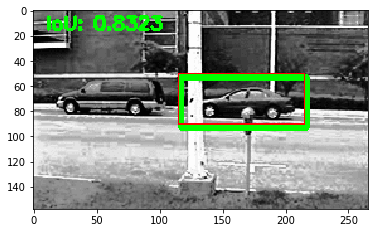

TestImages/106.pgm:  IOU = 0.0648
------------------------------------------


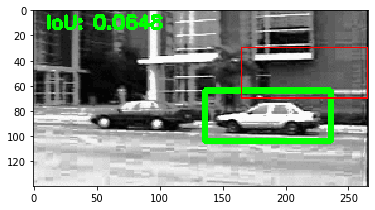

TestImages/107.pgm:  IOU = 0.9804
------------------------------------------


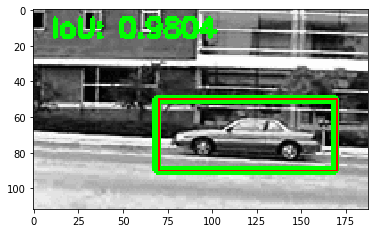

TestImages/108.pgm:  IOU = 0.0000
------------------------------------------


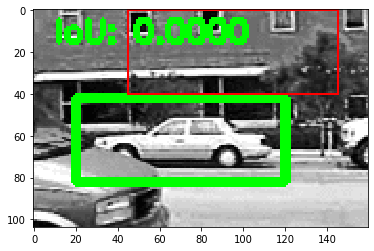

TestImages/109.pgm:  IOU = 0.8095
------------------------------------------


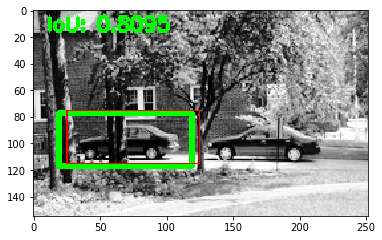

TestImages/110.pgm:  IOU = 0.7788
------------------------------------------


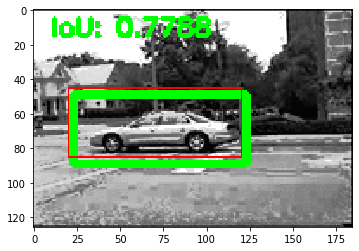

TestImages/111.pgm:  IOU = 0.1040
------------------------------------------


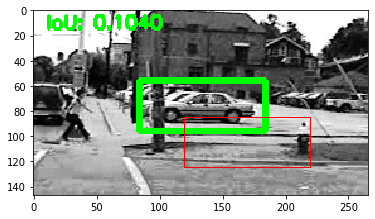

TestImages/112.pgm:  IOU = 0.8814
------------------------------------------


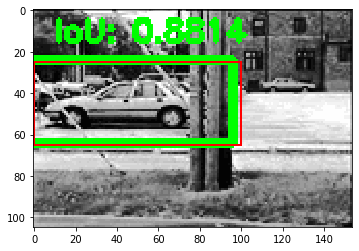

TestImages/113.pgm:  IOU = 0.9804
------------------------------------------


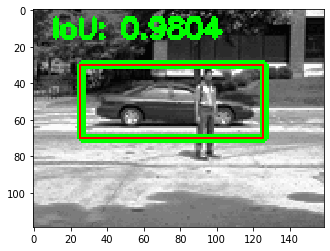

TestImages/114.pgm:  IOU = 0.7792
------------------------------------------


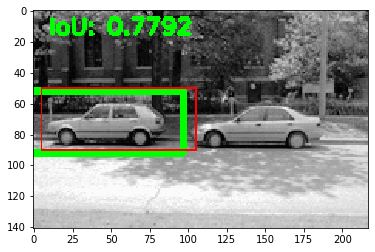

TestImages/115.pgm:  IOU = 0.9341
------------------------------------------


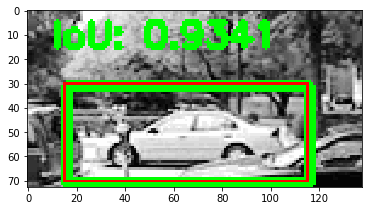

TestImages/116.pgm:  IOU = 0.7930
------------------------------------------


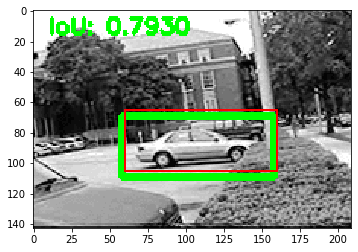

TestImages/117.pgm:  IOU = 0.8814
------------------------------------------


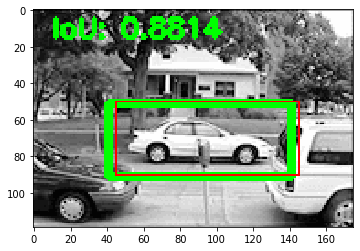

TestImages/118.pgm:  IOU = 0.9341
------------------------------------------


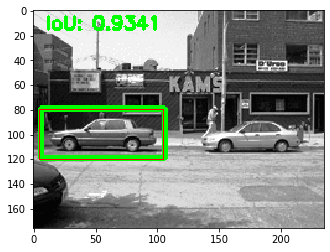

TestImages/119.pgm:  IOU = 0.8814
------------------------------------------


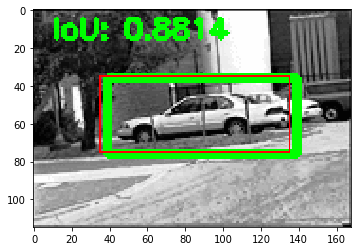

TestImages/120.pgm:  IOU = 0.9162
------------------------------------------


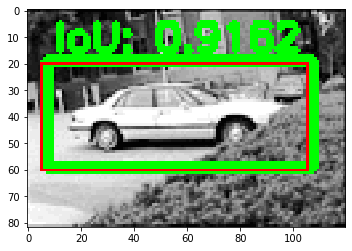

TestImages/121.pgm:  IOU = 0.9070
------------------------------------------


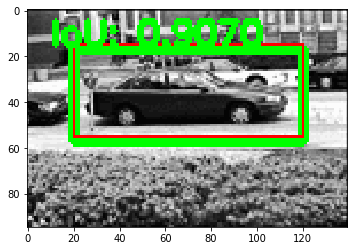

TestImages/122.pgm:  IOU = 0.8323
------------------------------------------


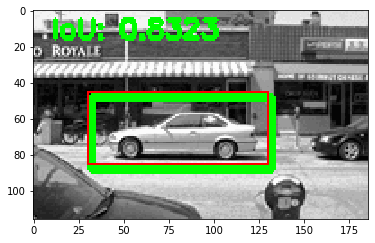

TestImages/123.pgm:  IOU = 0.8645
------------------------------------------


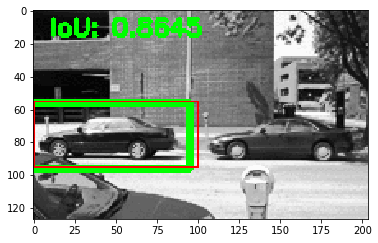

TestImages/124.pgm:  IOU = 0.9341
------------------------------------------


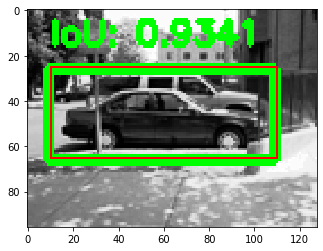

TestImages/125.pgm:  IOU = 0.9804
------------------------------------------


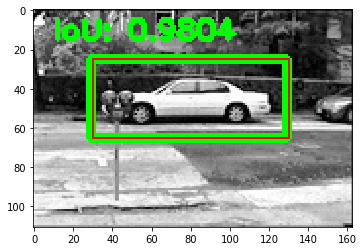

TestImages/126.pgm:  IOU = 0.9057
------------------------------------------


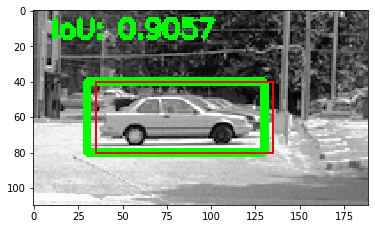

TestImages/127.pgm:  IOU = 0.7872
------------------------------------------


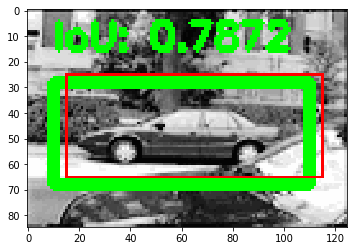

TestImages/128.pgm:  IOU = 0.8570
------------------------------------------


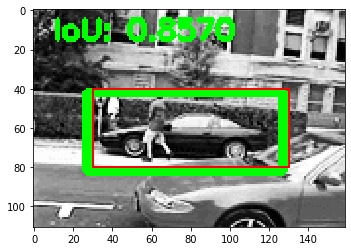

TestImages/129.pgm:  IOU = 0.9238
------------------------------------------


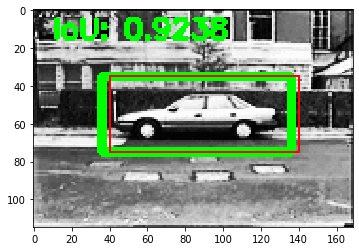

TestImages/130.pgm:  IOU = 0.0000
------------------------------------------


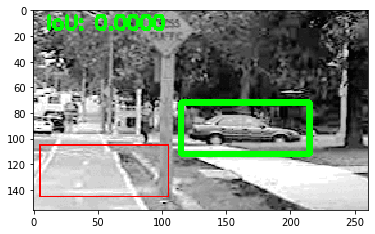

TestImages/131.pgm:  IOU = 0.0000
------------------------------------------


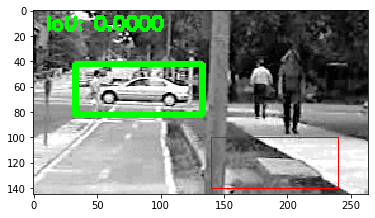

TestImages/132.pgm:  IOU = 0.0415
------------------------------------------


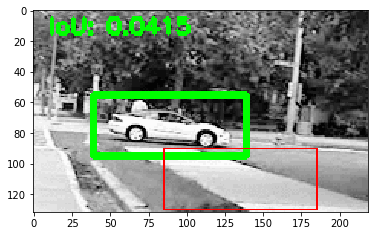

TestImages/133.pgm:  IOU = 0.8323
------------------------------------------


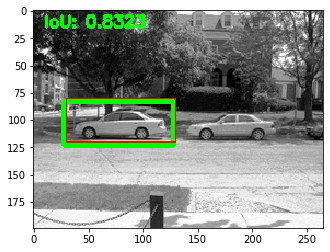

TestImages/134.pgm:  IOU = 0.9804
------------------------------------------


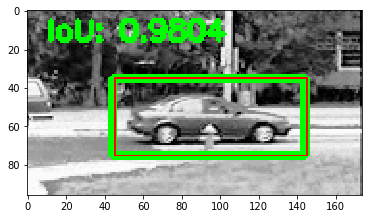

TestImages/135.pgm:  IOU = 0.8409
------------------------------------------


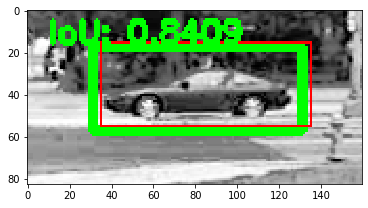

TestImages/136.pgm:  IOU = 0.9162
------------------------------------------


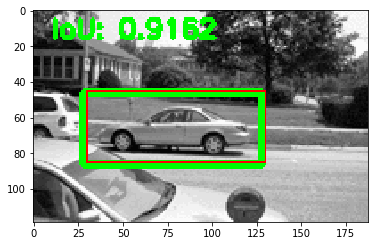

TestImages/137.pgm:  IOU = 0.8645
------------------------------------------


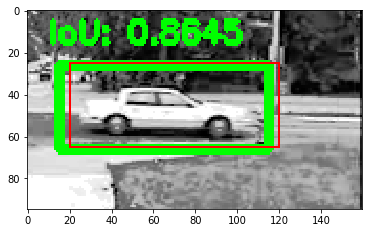

TestImages/138.pgm:  IOU = 0.8814
------------------------------------------


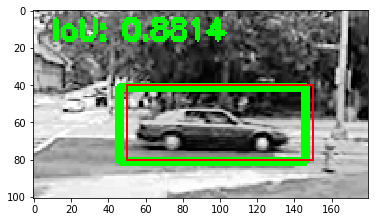

TestImages/139.pgm:  IOU = 0.8987
------------------------------------------


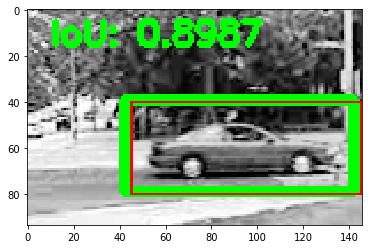

TestImages/140.pgm:  IOU = 0.9804
------------------------------------------


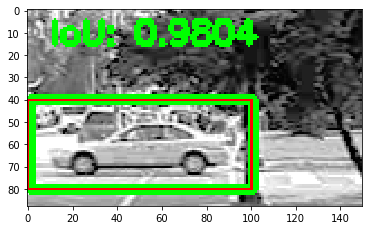

TestImages/141.pgm:  IOU = 0.0235
------------------------------------------


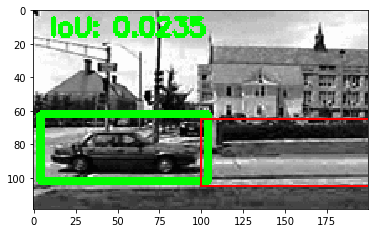

TestImages/142.pgm:  IOU = 0.9423
------------------------------------------


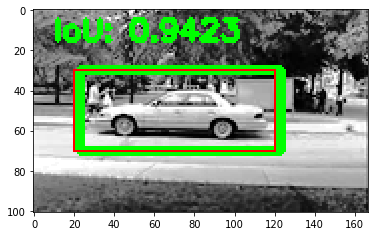

TestImages/143.pgm:  IOU = 0.9524
------------------------------------------


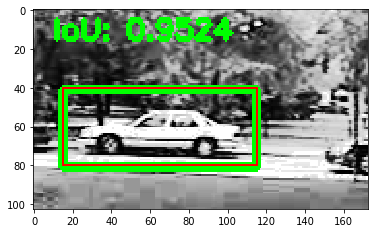

TestImages/144.pgm:  IOU = 0.9238
------------------------------------------


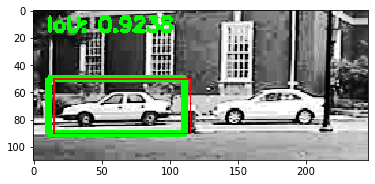

TestImages/145.pgm:  IOU = 0.9524
------------------------------------------


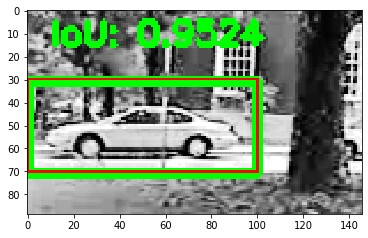

TestImages/146.pgm:  IOU = 0.6909
------------------------------------------


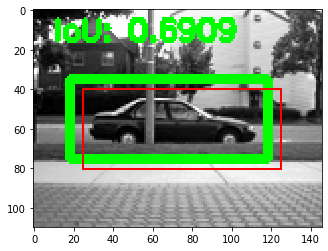

TestImages/147.pgm:  IOU = 0.8879
------------------------------------------


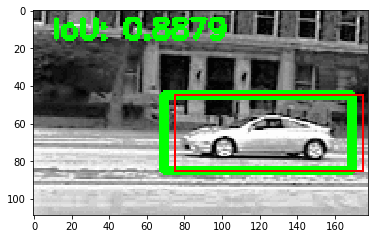

TestImages/148.pgm:  IOU = 0.2242
------------------------------------------


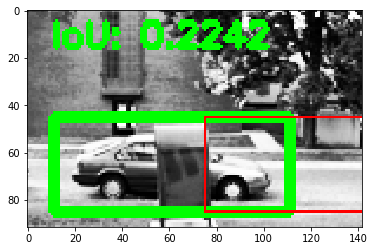

TestImages/149.pgm:  IOU = 0.8075
------------------------------------------


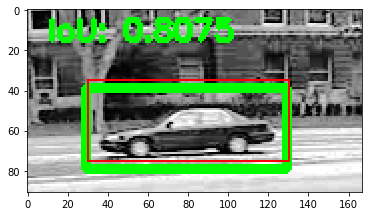

TestImages/150.pgm:  IOU = 0.9423
------------------------------------------


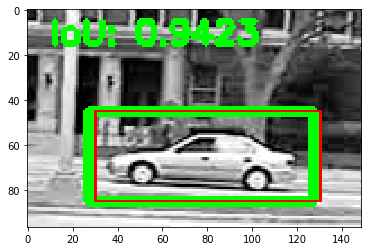

TestImages/151.pgm:  IOU = 0.9162
------------------------------------------


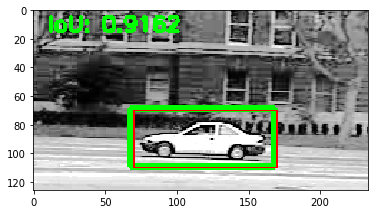

TestImages/152.pgm:  IOU = 1.0000
------------------------------------------


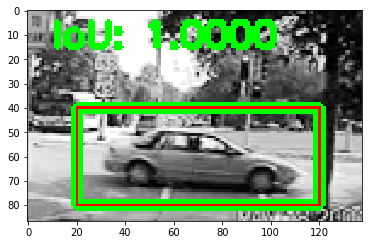

TestImages/153.pgm:  IOU = 0.8323
------------------------------------------


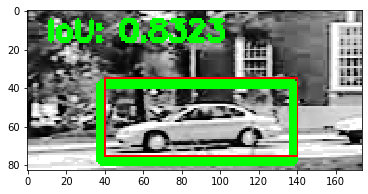

TestImages/154.pgm:  IOU = 0.9524
------------------------------------------


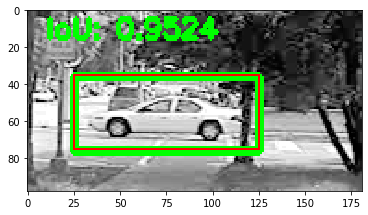

TestImages/155.pgm:  IOU = 0.9162
------------------------------------------


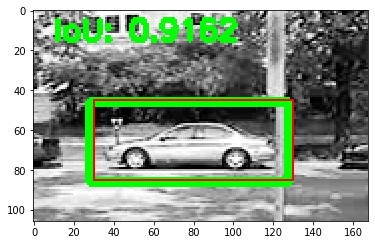

TestImages/156.pgm:  IOU = 0.9162
------------------------------------------


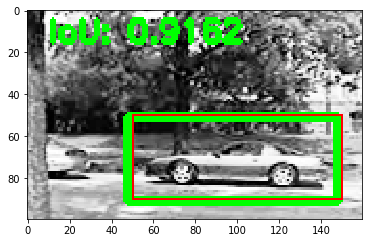

TestImages/157.pgm:  IOU = 0.2824
------------------------------------------


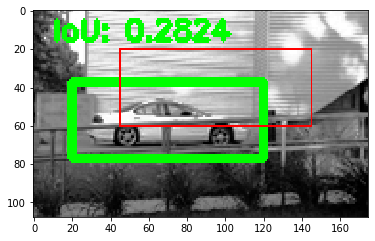

TestImages/158.pgm:  IOU = 0.8987
------------------------------------------


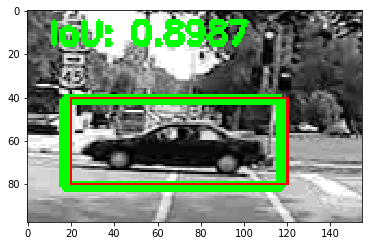

TestImages/159.pgm:  IOU = 0.9162
------------------------------------------


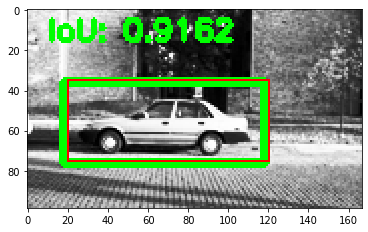

TestImages/160.pgm:  IOU = 0.8987
------------------------------------------


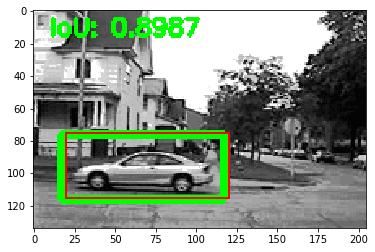

TestImages/161.pgm:  IOU = 0.8075
------------------------------------------


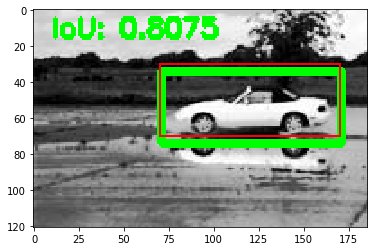

TestImages/162.pgm:  IOU = 0.9804
------------------------------------------


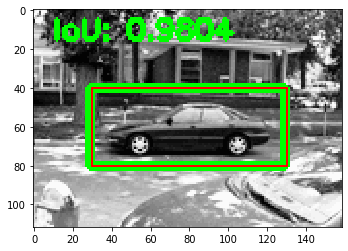

TestImages/163.pgm:  IOU = 0.9341
------------------------------------------


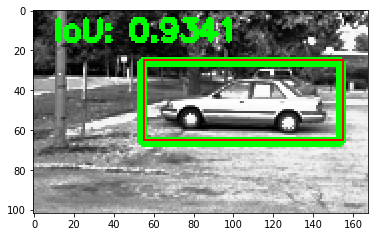

TestImages/164.pgm:  IOU = 0.8733
------------------------------------------


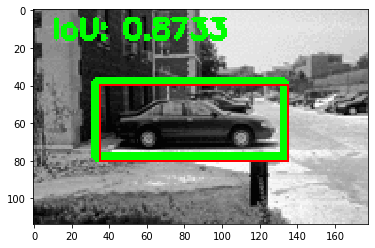

TestImages/165.pgm:  IOU = 0.9524
------------------------------------------


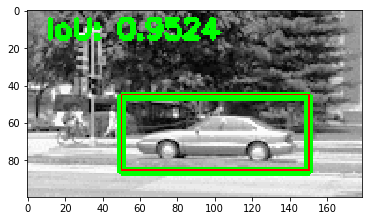

TestImages/166.pgm:  IOU = 0.8900
------------------------------------------


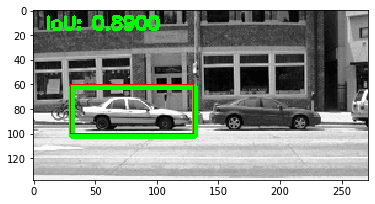

TestImages/167.pgm:  IOU = 0.8570
------------------------------------------


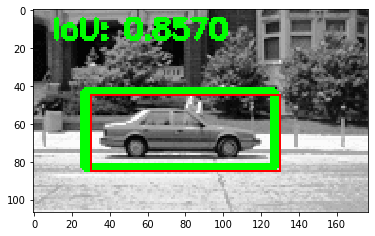

TestImages/168.pgm:  IOU = 0.8987
------------------------------------------


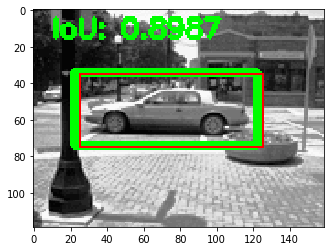

TestImages/169.pgm:  IOU = 0.8987
------------------------------------------


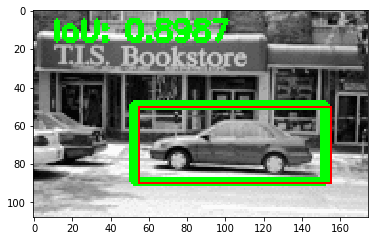

In [10]:
# i= image , z= x[gt] , o= y[gt] , x = x[pred], y = y[pred]
det = zip(i, o,z,x,y,w,h)
IOU=[]
for _ in det:
   # examples = [Detection(_[0], [t, u, t+100, u+40], [50, 30, 100, 40])]
    gt=[_[2], _[1], _[2]+100, _[1]+40]
    image_path=_[0]
    pred=[_[3], _[4], _[5]+_[3], _[6]+_[4]]
    # load the image
    image = cv2.imread(image_path)
    # draw the ground-truth bounding box along with the predicted
    # bounding box
    cv2.rectangle(image, tuple(gt[:2]), 
        tuple(gt[2:]), (0, 255, 0), 3)
    cv2.rectangle(image, tuple(pred[:2]), 
        tuple(pred[2:]), (255, 0, 0), 1)
    # compute the intersection over union and display it
    iou = bb_intersection_over_union(gt,pred)
    cv2.putText(image, "IoU: {:.4f}".format(iou), (10,15),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    IOU.append(iou)
    print("{}:  IOU = {:.4f}".format(image_path,iou))
    """
    print("x [gt]",_[2])
    print("y [gt]",_[1])
    print("x [pred]",_[3])
    print("y [pred]",_[4])
    print("------------------------------------------")
    print("w [gt]",_[2]+100)
    print("h [gt]",_[1]+40)
    print("w [pred]",_[5]+_[3])
    print("h [pred]",_[6]+_[4])"""
    print("------------------------------------------")
    # show the output image
    plt.imshow(image),plt.show()

In [11]:
import numpy as np

print("Mean of IOU = ",np.mean(np.array(IOU)))

Mean of IOU =  0.7259230069709943
